<h2>Imports</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

<h2>DataFrame einlesen</h2>

In [2]:
df = pd.read_pickle("data3.pkl")
df.head()

,image_id,caption_gt,score_siglip_gt,caption_modified,score_siglip_modified,caption_blip,score_siglip_blip,attribute_input,attribute_output
0,285,The large brown bear has a black nose.,0.156888,The large yellow bear has a black nose.,0.125476,a brown bear sitting in the grass,0.134214,brown,yellow
1,632,"Bedroom scene with a bookcase, blue comforter ...",0.172611,"Bedroom scene with a bookcase, yellow comforte...",0.134414,a bedroom with a bed and a window,0.141810,blue,yellow
2,776,Three stuffed bears hugging and sitting on a b...,0.173464,Three stuffed bears hugging and sitting on a g...,0.157350,a brown teddy bear,0.070526,blue,gray
3,785,A woman in a red jacket skiing down a slope,0.171473,A woman in a black jacket skiing down a slope,0.144893,a woman in a red jacket skiing down a hill,0.182639,red,black
4,802,A white oven and a white refrigerator are in t...,0.114765,A yellow oven and a white refrigerator are in ...,0.104644,a kitchen with a white refrigerator and a whit...,0.144552,white,yellow


<h2>CIDEr Score

In [3]:
#pip install git+https://github.com/salaniz/pycocoevalcap

In [4]:
from pycocoevalcap.cider.cider import Cider

cider_scorer = Cider()

def add_cider_column(df, gt_col: str, pred_col: str, out_col: str):
    ids = list(df.index)

    gts = {i: [df.loc[i, gt_col]] for i in ids}
    res = {i: [df.loc[i, pred_col]] for i in ids}

    _, scores = cider_scorer.compute_score(gts, res)
    df[out_col] = scores


In [5]:
# BLIP-Captions
add_cider_column(df, gt_col="caption_gt", pred_col="caption_blip", out_col="score_cider_blip")

df.head()
df.to_csv('generatedDataMasterSeminar.csv', index=False, sep=',', encoding='utf-8')


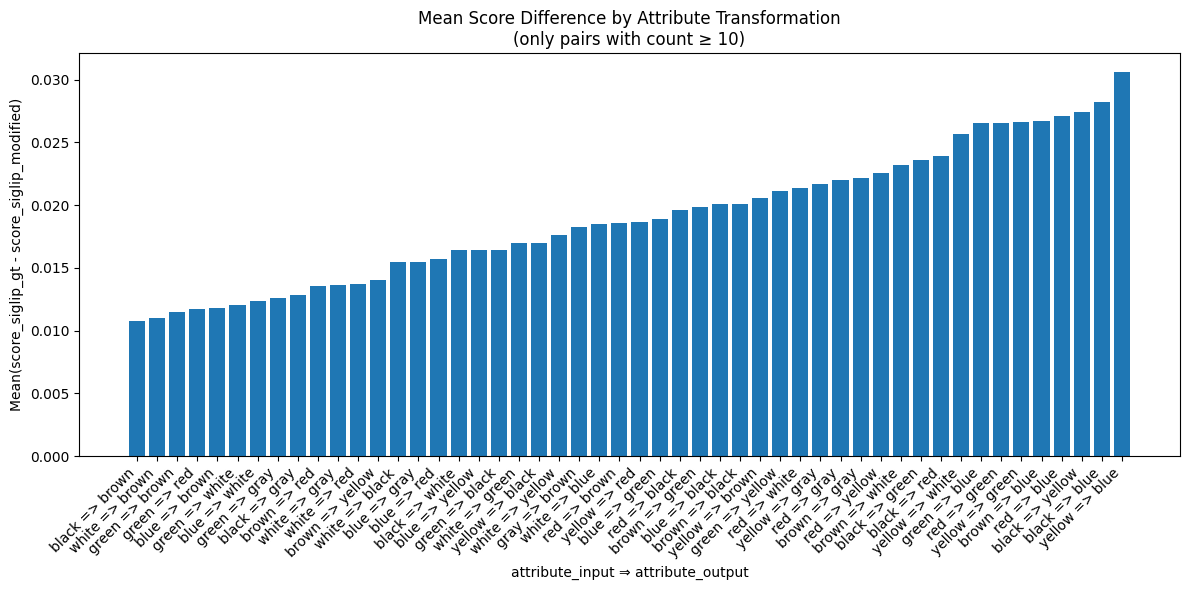

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df["attribute_pair"] = df["attribute_input"] + " => " + df["attribute_output"]

df["diff"] = df["score_siglip_gt"] - df["score_siglip_modified"]

grouped = (
    df.groupby("attribute_pair")["diff"]
    .agg(["mean", "count"])
    .reset_index()
)

grouped = grouped[grouped["count"] >= 10]

grouped = grouped.sort_values("mean", ascending=True)

plt.figure(figsize=(12, 6))
plt.bar(grouped["attribute_pair"], grouped["mean"])
plt.xlabel("attribute_input ⇒ attribute_output")
plt.ylabel("Mean(score_siglip_gt - score_siglip_modified)")
plt.title("Mean Score Difference by Attribute Transformation\n(only pairs with count ≥ 10)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [7]:
df.count()

image_id                 2357
caption_gt               2357
score_siglip_gt          2357
caption_modified         2357
score_siglip_modified    2357
caption_blip             2357
score_siglip_blip        2357
attribute_input          2186
attribute_output         2186
score_cider_blip         2357
attribute_pair           2186
diff                     2357
dtype: int64

In [8]:
df.groupby(["attribute_input", "attribute_output"]) \
  .size() \
  .reset_index(name="count")


,attribute_input,attribute_output,count
0,black,blue,70
1,black,brown,66
2,black,gray,50
3,black,green,49
4,black,red,55
5,black,white,44
6,black,yellow,53
7,blue,black,33
8,blue,brown,44
9,blue,gray,48


In [9]:
import numpy as np
from scipy.stats import pearsonr

print("--- EXPERIMENTAL RESULTS ---\n")

df['correct_prediction'] = df['score_siglip_gt'] > df['score_siglip_modified']
discriminative_accuracy = df['correct_prediction'].mean() * 100

print(f"RQ1 - Discriminative Accuracy: {discriminative_accuracy:.2f}%")

df['sensitivity_score'] = df['score_siglip_gt'] - df['score_siglip_modified']
mean_sensitivity = df['sensitivity_score'].mean()
std_sensitivity = df['sensitivity_score'].std()

negative_margins_pct = (df['sensitivity_score'] < 0).mean() * 100

print(f"RQ1 - Mean Sensitivity Score (Delta S): {mean_sensitivity:.6f} (Std: {std_sensitivity:.6f})")
print(f"RQ1 - Instances with Negative Margin (Hallucination preferred): {negative_margins_pct:.2f}%")
print("-" * 30 + "\n")

print("RQ2 - Color Bias Analysis (Top 5 Pairs with lowest sensitivity):")
color_bias = df.groupby(['attribute_input', 'attribute_output'])['sensitivity_score'].agg(['mean', 'count'])

robust_bias = color_bias[color_bias['count'] >= 10].sort_values(by='mean')

print(robust_bias.head(5))
print("-" * 30 + "\n")

avg_cider = df['score_cider_blip'].mean()
avg_visual_alignment = df['score_siglip_blip'].mean()

print(f"Generative - Average CIDEr Score: {avg_cider:.4f}")
print(f"Generative - Average Visual Alignment Score (SigLIP): {avg_visual_alignment:.4f}")

corr, p_value = pearsonr(df['score_cider_blip'], df['score_siglip_blip'])

print(f"Generative - Correlation (CIDEr vs. SigLIP): r = {corr:.4f} (p = {p_value:.4e})")

high_vis_low_cider = df[(df['score_siglip_blip'] > df['score_siglip_blip'].quantile(0.75)) & 
                        (df['score_cider_blip'] < df['score_cider_blip'].quantile(0.25))]

print(f"Generative - Number of high-vis/low-cider discrepant cases: {len(high_vis_low_cider)}")
print("-" * 30)

--- EXPERIMENTAL RESULTS ---

RQ1 - Discriminative Accuracy: 77.94%
RQ1 - Mean Sensitivity Score (Delta S): 0.016888 (Std: 0.018209)
RQ1 - Instances with Negative Margin (Hallucination preferred): 14.81%
------------------------------

RQ2 - Color Bias Analysis (Top 5 Pairs with lowest sensitivity):
                                      mean  count
attribute_input attribute_output                 
black           brown             0.010800     66
white           brown             0.011023     84
green           brown             0.011483     42
                red               0.011760     34
blue            brown             0.011825     44
------------------------------

Generative - Average CIDEr Score: 0.7676
Generative - Average Visual Alignment Score (SigLIP): 0.1088
Generative - Correlation (CIDEr vs. SigLIP): r = 0.2275 (p = 4.7155e-29)
Generative - Number of high-vis/low-cider discrepant cases: 97
------------------------------


<h2>Similarity Difference ΔS

In [10]:
df["delta_score"] = df["score_siglip_gt"] - df["score_siglip_modified"]

delta_stats = df["delta_score"].describe() 

prop_negative = (df["delta_score"] < 0).mean()

print("ΔS statistics:")
print(delta_stats)
print("\nProportion of samples with ΔS < 0 (score_modified > score_gt):", prop_negative)


ΔS statistics:
count    2357.000000
mean        0.016888
std         0.018209
min        -0.053531
25%         0.002102
50%         0.016067
75%         0.028248
max         0.093636
Name: delta_score, dtype: float64

Proportion of samples with ΔS < 0 (score_modified > score_gt): 0.14806957997454392


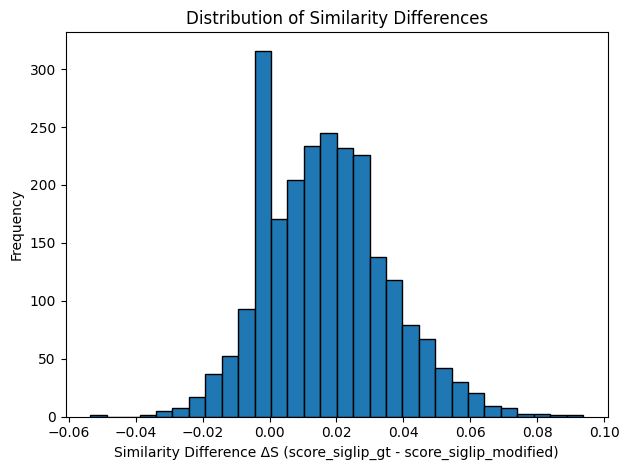

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["delta_score"], bins=30, edgecolor="black")
plt.xlabel("Similarity Difference ΔS (score_siglip_gt - score_siglip_modified)")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Differences")
plt.tight_layout()
plt.show()


<h2>Relative Similarity Drop (RSD)</h2>

In [12]:
df["rsd"] = (df["score_siglip_gt"] - df["score_siglip_modified"]) / df["score_siglip_gt"]

rsd_stats = df["rsd"].describe()

prop_negative_rsd = (df["rsd"] < 0).mean()

print("RSD statistics:")
print(rsd_stats)
print("\nProportion of samples with RSD < 0:", prop_negative_rsd)


RSD statistics:
count    2357.000000
mean        0.125054
std         0.170356
min        -3.208310
25%         0.018205
50%         0.116523
75%         0.210677
max         1.599169
Name: rsd, dtype: float64

Proportion of samples with RSD < 0: 0.14806957997454392


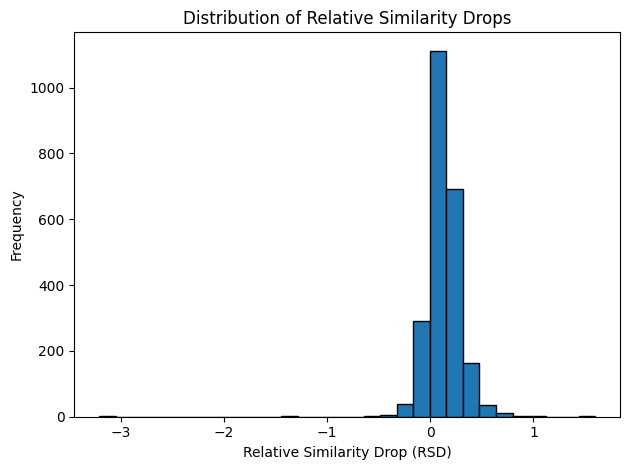

In [13]:
plt.figure()
plt.hist(df["rsd"], bins=30, edgecolor="black")
plt.xlabel("Relative Similarity Drop (RSD)")
plt.ylabel("Frequency")
plt.title("Distribution of Relative Similarity Drops")
plt.tight_layout()
plt.show()


<h2>Misranking: score_modified > score_gt</h2>

In [14]:
df["misrank"] = (df["score_siglip_modified"] > df["score_siglip_gt"]).astype(int)

misrank_rate = df["misrank"].mean()
misrank_count = df["misrank"].sum()

print("Misranking Rate:", misrank_rate)
print("Number of misranked samples:", misrank_count, "out of", len(df))


Misranking Rate: 0.14806957997454392
Number of misranked samples: 349 out of 2357


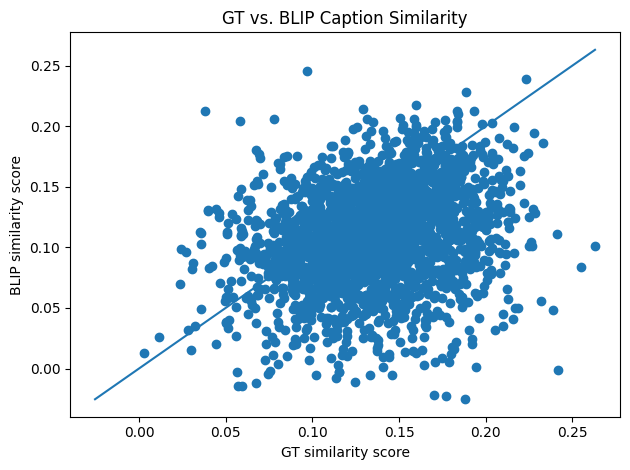

In [15]:
plt.figure()
plt.scatter(df["score_siglip_gt"], df["score_siglip_blip"])
plt.xlabel("GT similarity score")
plt.ylabel("BLIP similarity score")
plt.title("GT vs. BLIP Caption Similarity")
min_val = min(df["score_siglip_gt"].min(), df["score_siglip_blip"].min())
max_val = max(df["score_siglip_gt"].max(), df["score_siglip_blip"].max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.tight_layout()
plt.show()


In [16]:
from scipy.stats import pearsonr, spearmanr

pearson_gt_mod, _ = pearsonr(df["score_siglip_gt"], df["score_siglip_modified"])
pearson_gt_blip, _ = pearsonr(df["score_siglip_gt"], df["score_siglip_blip"])
pearson_mod_blip, _ = pearsonr(df["score_siglip_modified"], df["score_siglip_blip"])

spearman_gt_mod, _ = spearmanr(df["score_siglip_gt"], df["score_siglip_modified"])
spearman_gt_blip, _ = spearmanr(df["score_siglip_gt"], df["score_siglip_blip"])
spearman_mod_blip, _ = spearmanr(df["score_siglip_modified"], df["score_siglip_blip"])

print("Pearson Correlations:")
print("GT vs Modified:", pearson_gt_mod)
print("GT vs BLIP:", pearson_gt_blip)
print("Modified vs BLIP:", pearson_mod_blip)

print("\nSpearman Correlations:")
print("GT vs Modified:", spearman_gt_mod)
print("GT vs BLIP:", spearman_gt_blip)
print("Modified vs BLIP:", spearman_mod_blip)


Pearson Correlations:
GT vs Modified: 0.8795546693622862
GT vs BLIP: 0.253029694250778
Modified vs BLIP: 0.25744984542875776

Spearman Correlations:
GT vs Modified: 0.8698681184405785
GT vs BLIP: 0.2680175742019631
Modified vs BLIP: 0.2756987227749934


<h2>Boxplot der ΔCLIP-Scores pro Attributkombination</h2>

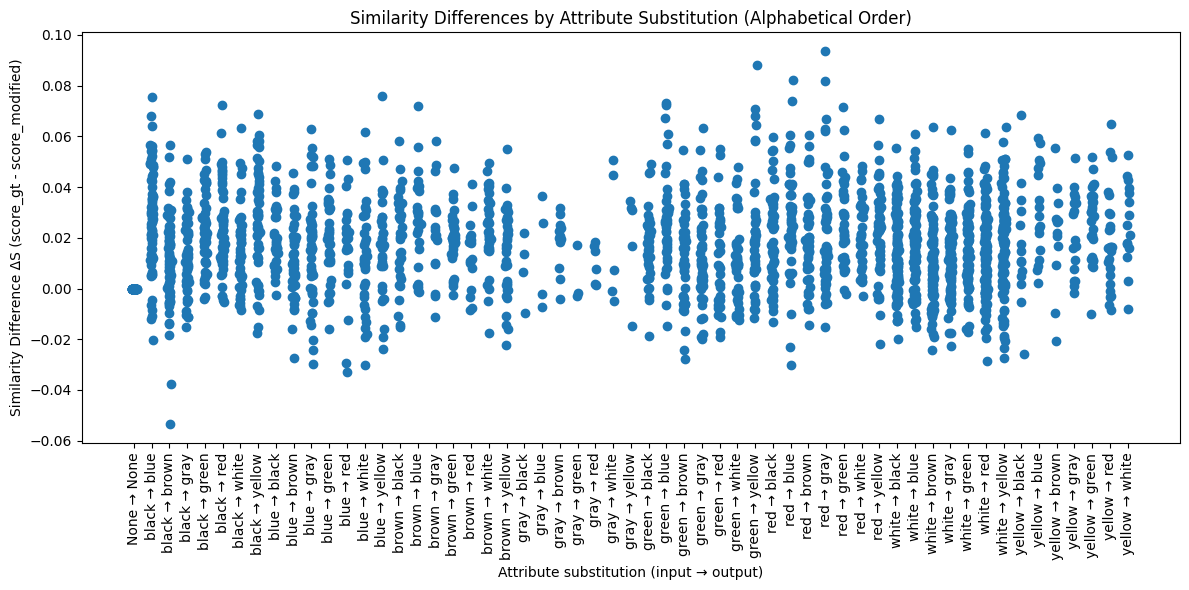

In [17]:
import matplotlib.pyplot as plt
import numpy as np

df["attribute_input"] = df["attribute_input"].astype(str)
df["attribute_output"] = df["attribute_output"].astype(str)

df["attribute_pair"] = df["attribute_input"] + " → " + df["attribute_output"]

mask_valid = ~df["attribute_pair"].str.contains("nan")
df_pairs = df[mask_valid].copy()

unique_pairs = sorted(df_pairs["attribute_pair"].unique())

pair_to_x = {pair: i for i, pair in enumerate(unique_pairs)}

x_base = df_pairs["attribute_pair"].map(pair_to_x).values
x_jitter = x_base + np.random.normal(loc=0.0, scale=0.05, size=len(df_pairs))

plt.figure(figsize=(12, 6))
plt.scatter(x_jitter, df_pairs["delta_score"])
plt.xticks(ticks=range(len(unique_pairs)), labels=unique_pairs, rotation=90)
plt.xlabel("Attribute substitution (input → output)")
plt.ylabel("Similarity Difference ΔS (score_gt - score_modified)")
plt.title("Similarity Differences by Attribute Substitution (Alphabetical Order)")
plt.tight_layout()
plt.show()


<h2>Misranking Rate pro Attributpaar (direktes Halluzinationsmaß)</h2>

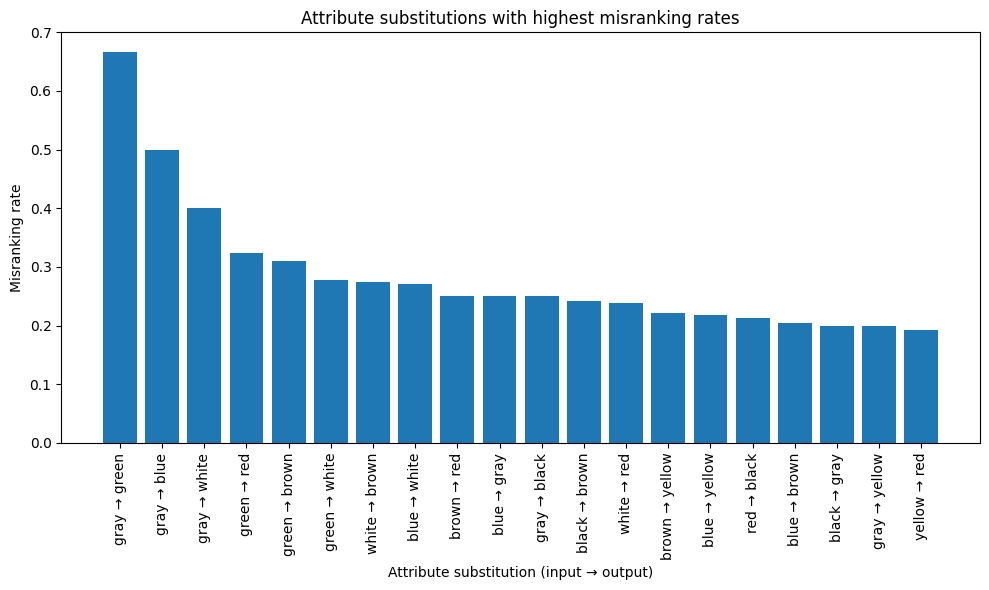

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

if "misrank" not in df.columns:
    df["misrank"] = (df["score_modified"] > df["score_siglip_gt"]).astype(int)

df["attribute_pair"] = df["attribute_input"].astype(str) + " → " + df["attribute_output"].astype(str)

pair_misrank = df.groupby("attribute_pair")["misrank"].mean().sort_values(ascending=False)

top_n = 20
pair_misrank_top = pair_misrank.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(range(len(pair_misrank_top)), pair_misrank_top.values)
plt.xticks(range(len(pair_misrank_top)), pair_misrank_top.index, rotation=90)
plt.ylabel("Misranking rate")
plt.xlabel("Attribute substitution (input → output)")
plt.title("Attribute substitutions with highest misranking rates")
plt.tight_layout()
plt.show()


<h2>Mittlere ΔS pro Attributpaar (geringste Sensitivität)</h2>

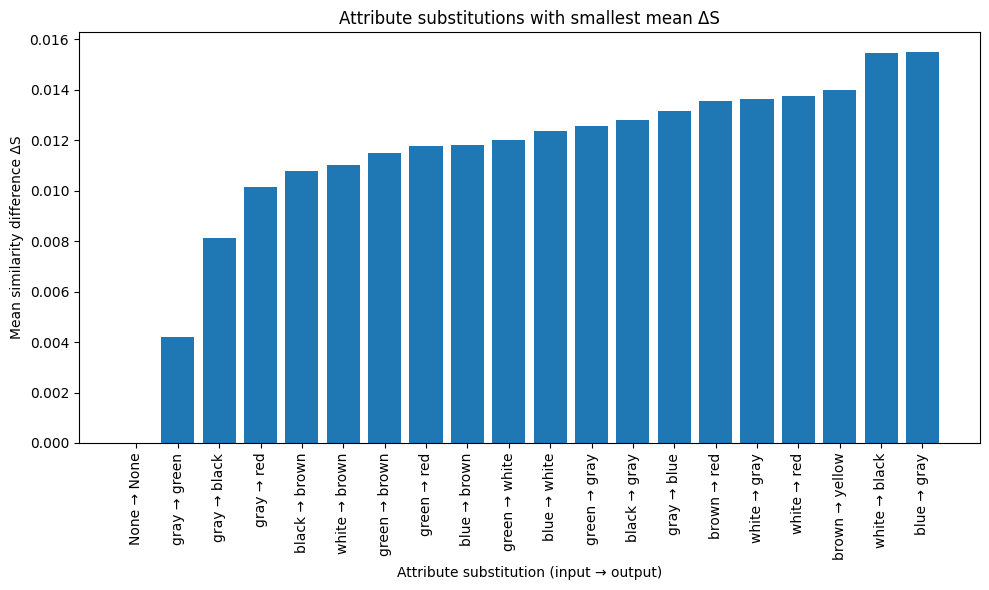

In [19]:
pair_delta = df.groupby("attribute_pair")["delta_score"].mean().sort_values()  # aufsteigend: kleinste ΔS zuerst

top_n = 20 
pair_delta_top = pair_delta.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(range(len(pair_delta_top)), pair_delta_top.values)
plt.xticks(range(len(pair_delta_top)), pair_delta_top.index, rotation=90)
plt.ylabel("Mean similarity difference ΔS")
plt.xlabel("Attribute substitution (input → output)")
plt.title("Attribute substitutions with smallest mean ΔS")
plt.tight_layout()
plt.show()


In [20]:
if "delta_score" not in df.columns:
    df["delta_score"] = df["score_siglip_gt"] - df["score_siglip_modified"]

df_worst = df.sort_values(by="delta_score", ascending=True)

df_worst_subset = df_worst[[
    "image_id",
    "caption_gt",
    "score_siglip_gt",
    "caption_modified",
    "score_siglip_modified",
    "delta_score",
    "attribute_input",
    "attribute_output"
]]

df_worst_subset.head(10)


,image_id,caption_gt,score_siglip_gt,caption_modified,score_siglip_modified,delta_score,attribute_input,attribute_output
929,231508,A man in black jersey pitching in baseball game.,0.115793,A man in brown jersey pitching in baseball game.,0.169323,-0.053531,black,brown
362,89697,A black and white photo of a couple sitting on...,0.169418,A brown and white photo of a couple sitting on...,0.207046,-0.037628,black,brown
1062,264335,A bird flying through a blue sky with wide wings.,0.134018,A bird flying through a red sky with wide wings.,0.166923,-0.032906,blue,red
555,138819,A bathroom sink beside a toilet and blue trash...,0.086778,A bathroom sink beside a toilet and white tras...,0.116817,-0.030038,blue,white
1467,364636,A mixed breed dog in a red collar pants in the...,0.141185,A mixed breed dog in a blue collar pants in th...,0.171192,-0.030007,red,blue
1994,491757,A cat with blue eyes sitting on a pink bed.,0.159595,A cat with gray eyes sitting on a pink bed.,0.189323,-0.029728,blue,gray
389,97278,A woman in blue jacket standing on a snowboard.,0.103088,A woman in red jacket standing on a snowboard.,0.132528,-0.029440,blue,red
1862,460494,Assorted meal sitting on a plate with a white ...,0.069590,Assorted meal sitting on a plate with a red gl...,0.098226,-0.028636,white,red
246,58384,Three elephants in a cage at a green field.,0.124600,Three elephants in a cage at a brown field.,0.152549,-0.027948,green,brown
1184,295478,A woman walking a small white dog down a street.,0.149561,A woman walking a small yellow dog down a street.,0.176914,-0.027353,white,yellow


In [21]:
import numpy as np

mean_gt = df["score_siglip_gt"].mean()
mean_mod = df["score_siglip_modified"].mean()
mean_blip = df["score_siglip_blip"].mean()  

std_gt = df["score_siglip_gt"].std()
std_mod = df["score_siglip_modified"].std()
std_blip = df["score_siglip_blip"].std()

print("Mean SigLIP similarity:")
print(f"  Ground-truth:   {mean_gt:.4f} (std {std_gt:.4f})")
print(f"  Modified:       {mean_mod:.4f} (std {std_mod:.4f})")
print(f"  BLIP-generated: {mean_blip:.4f} (std {std_blip:.4f})")


Mean SigLIP similarity:
  Ground-truth:   0.1353 (std 0.0368)
  Modified:       0.1185 (std 0.0374)
  BLIP-generated: 0.1088 (std 0.0407)


In [22]:
df["delta_s"] = df["score_siglip_gt"] - df["score_siglip_modified"]

top5_lowest = df.sort_values("delta_s", ascending=True).head(5)

print(top5_lowest[["image_id","caption_gt","caption_modified","attribute_input", "attribute_output", "delta_s"]])


      image_id                                         caption_gt  \
929     231508   A man in black jersey pitching in baseball game.   
362      89697  A black and white photo of a couple sitting on...   
1062    264335  A bird flying through a blue sky with wide wings.   
555     138819  A bathroom sink beside a toilet and blue trash...   
1467    364636  A mixed breed dog in a red collar pants in the...   

                                       caption_modified attribute_input  \
929    A man in brown jersey pitching in baseball game.           black   
362   A brown and white photo of a couple sitting on...           black   
1062   A bird flying through a red sky with wide wings.            blue   
555   A bathroom sink beside a toilet and white tras...            blue   
1467  A mixed breed dog in a blue collar pants in th...             red   

     attribute_output   delta_s  
929             brown -0.053531  
362             brown -0.037628  
1062              red -0.032906 

In [23]:
worst_failures = df.sort_values(by='sensitivity_score', ascending=True).head(10)

print("--- TOP 10 WORST FAILURES (Model strongly preferred hallucination) ---")

for index, row in worst_failures.iterrows():
    print(f"Image ID: {row['image_id']}")
    print(f"Input Color (GT): {row['attribute_input']} | Output Color (Hallucinated): {row['attribute_output']}")
    print(f"Caption GT:       {row['caption_gt']}")
    print(f"Caption Modified: {row['caption_modified']}")
    print(f"Sensitivity Score: {row['sensitivity_score']:.4f}")
    print("-" * 50)


--- TOP 10 WORST FAILURES (Model strongly preferred hallucination) ---
Image ID: 231508
Input Color (GT): black | Output Color (Hallucinated): brown
Caption GT:       A man in black jersey pitching in baseball game.
Caption Modified: A man in brown jersey pitching in baseball game.
Sensitivity Score: -0.0535
--------------------------------------------------
Image ID: 89697
Input Color (GT): black | Output Color (Hallucinated): brown
Caption GT:       A black and white photo of a couple sitting on two park benches.
Caption Modified: A brown and white photo of a couple sitting on two park benches.
Sensitivity Score: -0.0376
--------------------------------------------------
Image ID: 264335
Input Color (GT): blue | Output Color (Hallucinated): red
Caption GT:       A bird flying through a blue sky with wide wings.
Caption Modified: A bird flying through a red sky with wide wings.
Sensitivity Score: -0.0329
--------------------------------------------------
Image ID: 138819
Input Color (